<a href="https://colab.research.google.com/github/kennyluu130/Obesity-Level-Prediction-With-Neural-Networks/blob/main/ObesityLevelPredictionWithNeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Obesity Level Prediction With Neural Networks

- Kenny Luu
- UCLA 2027
- Computer Science and Linguistics
- Data Science Engineering

###Imports

In [ ]:
#Data Manipulation & Preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.utils import to_categorical

#Machine Learning / Neural Networks
import tensorflow as tf
from tensorflow.keras import models, layers

#Metrics & Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#Visualization
import matplotlib.pyplot as plt

#Utilities / Dataset Access
import requests
import io


### Read Dataframe

In [ ]:
# Load dataset from Google Drive
file_url = "https://drive.google.com/file/d/1GNogY6Ezx3zQVvfmDWK4Hsik5Lo3hp4W/view?usp=drive_link"
file_id = file_url.split("/")[-2]

#URL
url = f"https://drive.google.com/uc?id={file_id}&export=download"

# Send a GET request for binary content
response = requests.get(url)
content = response.content

# Load csv to pandas dataframe
df = pd.read_csv(io.StringIO(content.decode('utf-8')))

###Initial Data Exploration

In [ ]:
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [ ]:
print("\nSummary:\n", df.describe())
print("\nMissing values:\n", df.isnull().sum())
print("\nShape:\n", df.shape)


Summary:
                Age       Height       Weight         FCVC          NCP  \
count  2111.000000  2111.000000  2111.000000  2111.000000  2111.000000   
mean     24.312600     1.701677    86.586058     2.419043     2.685628   
std       6.345968     0.093305    26.191172     0.533927     0.778039   
min      14.000000     1.450000    39.000000     1.000000     1.000000   
25%      19.947192     1.630000    65.473343     2.000000     2.658738   
50%      22.777890     1.700499    83.000000     2.385502     3.000000   
75%      26.000000     1.768464   107.430682     3.000000     3.000000   
max      61.000000     1.980000   173.000000     3.000000     4.000000   

              CH2O          FAF          TUE  
count  2111.000000  2111.000000  2111.000000  
mean      2.008011     1.010298     0.657866  
std       0.612953     0.850592     0.608927  
min       1.000000     0.000000     0.000000  
25%       1.584812     0.124505     0.000000  
50%       2.000000     1.000000     0.62

###Data Preprocessing

In [ ]:
#Separate features and target
target_col = "NObeyesdad" #obesity levels
X = df.drop(columns=[target_col])
y = df[target_col]

In [ ]:
#Encode target labels as integers
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y)

In [ ]:
#Preprocess features
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
continuous_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
#One-hot encode categorical features
encoder_dict = {}
for col in categorical_cols:
    encoder = OneHotEncoder(sparse_output=False, drop=None, handle_unknown='ignore')
    transformed = encoder.fit_transform(X[[col]])
    new_cols = [f"{col}_{cat}" for cat in encoder.categories_[0]]
    df_transformed = pd.DataFrame(transformed, columns=new_cols, index=X.index)
    X.drop(columns=[col], inplace=True)
    X[new_cols] = df_transformed
    encoder_dict[col] = encoder

In [ ]:
#Standard scaler for continuous features
scaler = StandardScaler()
X[continuous_cols] = scaler.fit_transform(X[continuous_cols])

In [ ]:
#Train/test split 80/20
X_train, X_test, y_train_int, y_test_int = train_test_split(
    X, y_int,
    test_size=0.2,
    random_state=42,
    stratify=y_int
)

In [ ]:
#Oversample minority classes
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled_int = ros.fit_resample(X_train, y_train_int)

In [ ]:
#Convert labels to one-hot for Keras
num_classes = len(label_encoder.classes_)
y_train_resampled = to_categorical(y_train_resampled_int, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_int, num_classes=num_classes)

In [ ]:
#Check
print("X_train shape:", X_train_resampled.shape)
print("y_train shape:", y_train_resampled.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test_categorical.shape)

X_train shape: (1967, 31)
y_train shape: (1967, 7)
X_test shape: (423, 31)
y_test shape: (423, 7)


###Neural Network

In [ ]:
#Neural Network Model
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    layers.Dropout(0.4),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.Dense(y_train_resampled.shape[1], activation='softmax')  # output layer
])

#Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Call backs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
#Train Model
history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.2369 - loss: 1.8823 - val_accuracy: 0.4442 - val_loss: 1.2994 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5199 - loss: 1.1965 - val_accuracy: 0.7589 - val_loss: 0.7934 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6498 - loss: 0.8732 - val_accuracy: 0.7792 - val_loss: 0.6586 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6742 - loss: 0.7828 - val_accuracy: 0.8299 - val_loss: 0.5204 - learning_rate: 0.0010
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7331 - loss: 0.6408 - val_accuracy: 0.8579 - val_loss: 0.4389 - learning_rate: 0.0010
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7709 - loss: 0.5528 - val_accuracy: 0.9061 - val_loss: 0.3672 - learning_rate: 0.0010
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7961 - loss: 0.5040 - val_accuracy:

In [ ]:
#Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
#Classification report
report = classification_report(y_test_int, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:\n")
print(report)

Classification Report:

                     precision    recall  f1-score   support

Insufficient_Weight       0.96      1.00      0.98        54
      Normal_Weight       0.94      0.83      0.88        58
     Obesity_Type_I       0.97      0.99      0.98        70
    Obesity_Type_II       0.98      0.98      0.98        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.83      0.91      0.87        58
Overweight_Level_II       0.95      0.93      0.94        58

           accuracy                           0.95       423
          macro avg       0.95      0.95      0.95       423
       weighted avg       0.95      0.95      0.95       423



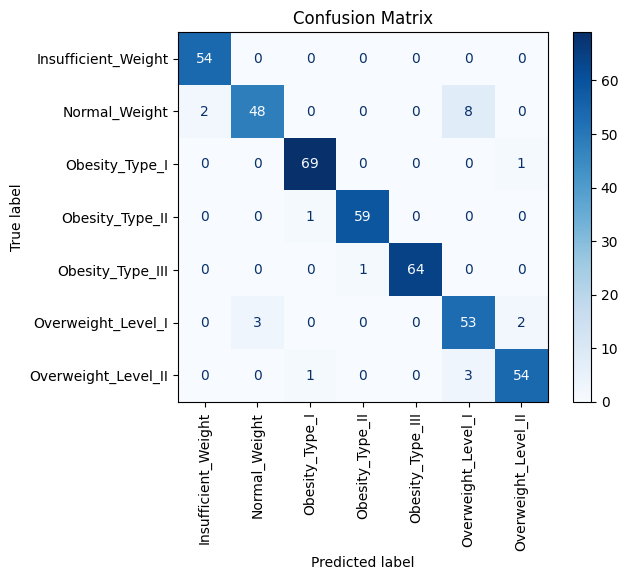

In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_int, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), rotation=90) # Rotate x-axis labels vertically

plt.title("Confusion Matrix")
plt.show()